# CONV1 with Constituent Tree Parse (part 1)

In [20]:
import numpy as np
import pandas as pd
import os
import gc

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline  

## Get Data

In [18]:
# file PubMed_20k_RCT.csv created by script01_create_single_dataset
df_all = pd.read_csv('input/PubMed_20k_RCT_CONSTPARSE.csv')
df_train = df_all[df_all['partition']=='train']
df_valid = df_all[df_all['partition']=='dev']
df_test = df_all[df_all['partition']=='test']
pd.set_option('max_colwidth',500)
df_all.head()

,partition,abstract_id,seq,text,label,deptree,deptree2
0,train,4293578,0,"To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .",OBJECTIVE,"( ROOT ( S ( S ( VP ( TO ) ( VP ( VB ) ( NP ( NP ( DT ) ( NN ) ) ( PP ( IN ) ( NP ( NP ( CD ) ( NNS ) ) ( PP ( IN ) ( NP ( JJ ) ( JJ ) ( JJ ) ( NN ) ) ) ) ) ) ( PP ( IN ) ( S ( VP ( VBG ) ( NP ( NP ( NN ) ) ( , ) ( NP ( NN ) ) ( , ) ( CC ) ( NP ( NP ( JJ ) ( JJ ) ( NN ) ) ( PP ( IN ) ( NP ( DT ) ( JJ ) ( NN ) ) ) ) ) ) ) ) ) ) ) ( CC ) ( S ( NP ( IN ) ( DT ) ( NN ) ) ( VP ( MD ) ( VP ( VB ) ( VP ( VBN ) ( PP ( IN ) ( NP ( NP ( CD ) ( NNS ) ) ( PP ( IN ) ( NP ( NP ( JJR ) ( NNS ) ) ( PP ( IN ...","( ROOT ( S ( S ( VP ( TO ) ( VP ( VB ) ( NP ( NP ( DT ) ( NN ) ) ( PP ( IN ) ( NP ( NP ( CD ) ( NNS ) ) ( PP ( IN ) ( NP ( JJ ) ( JJ ) ( JJ ) ( NN ) ) ) ) ) ) ( PP ( IN ) ( S ( VP ( VBG ) ( NP ( NP ( NN ) ) ( , ) ( NP ( NN ) ) ( , ) ( CC ) ( NP ( NP ( JJ ) ( JJ ) ( NN ) ) ( PP ( IN ) ( NP ( DT ) ( JJ ) ( NN ) ) ) ) ) ) ) ) ) ) ) ( CC ) ( S ( NP ( IN ) ( DT ) ( NN ) ) ( VP ( MD ) ( VP ( VB ) ( VP ( VBN ) ( PP ( IN ) ( NP ( NP ( CD ) ( NNS ) ) ( PP ( IN ) ( NP ( NP ( JJR ) ( NNS ) ) ( PP ( IN ..."
1,train,4293578,1,A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .,METHODS,( ROOT ( S ( S ( NP ( NP ( DT ) ( NN ) ) ( PP ( IN ) ( NP ( NP ( CD ) ( NNS ) ) ( PP ( IN ) ( NP ( JJ ) ( NN ) ( NN ) ) ) ) ) ) ( VP ( VBD ) ( VP ( VBN ) ( NP ( CD ) ) ) ) ) ( : ) ( S ( NP ( CD ) ) ( VP ( VBD ) ( SBAR ( S ( NP ( NP ( CD ) ( NN mg/day ) ) ( PP ( IN ) ( NP ( NP ( NN ) ) ( CC ) ( NP ( CD ) ) ) ) ) ( VP ( VBD ) ( NP ( NN ) ) ( PP ( IN ) ( NP ( CD ) ( NNS ) ) ) ) ) ) ) ) ( . ) ) ),( ROOT ( S ( S ( NP ( NP ( DT ) ( NN ) ) ( PP ( IN ) ( NP ( NP ( CD ) ( NNS ) ) ( PP ( IN ) ( NP ( JJ ) ( NN ) ( NN ) ) ) ) ) ) ( VP ( VBD ) ( VP ( VBN ) ( NP ( CD ) ) ) ) ) ( ( S ( NP ( CD ) ) ( VP ( VBD ) ( SBAR ( S ( NP ( NP ( CD ) ( NN ) ( PP ( IN ) ( NP ( NP ( NN ) ) ( CC ) ( NP ( CD ) ) ) ) ) ( VP ( VBD ) ( NP ( NN ) ) ( PP ( IN ) ( NP ( CD ) ( NNS ) ) ) ) ) ) ) ) ( . ) ) )
2,train,4293578,2,Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .,METHODS,( ROOT ( S ( NP ( NN ) ( NNS ) ) ( VP ( VBD ) ( NP ( NN ) ( NN ) ( CC ) ( NN ) ) ( PP ( IN ) ( NP ( NP ( NN ) ( NNS ) ) ( CC ) ( NP ( JJ ) ( NN ) ( NNS ) ) ) ) ) ( . ) ) ),( ROOT ( S ( NP ( NN ) ( NNS ) ) ( VP ( VBD ) ( NP ( NN ) ( NN ) ( CC ) ( NN ) ) ( PP ( IN ) ( NP ( NP ( NN ) ( NNS ) ) ( CC ) ( NP ( JJ ) ( NN ) ( NNS ) ) ) ) ) ( . ) ) )
3,train,4293578,3,Pain was assessed using the visual analog pain scale ( 0-100 mm ) .,METHODS,( ROOT ( S ( NP ( NN ) ) ( VP ( VBD ) ( VP ( VBN ) ( S ( VP ( VBG ) ( NP ( NP ( DT ) ( JJ ) ( NN ) ( NN ) ( NN ) ) ( PRN ( -LRB- ) ( NP ( CD ) ( NN ) ) ( -RRB- ) ) ) ) ) ) ) ( . ) ) ),( ROOT ( S ( NP ( NN ) ) ( VP ( VBD ) ( VP ( VBN ) ( S ( VP ( VBG ) ( NP ( NP ( DT ) ( JJ ) ( NN ) ( NN ) ( NN ) ) ( PRN ( LRB ) ( NP ( CD ) ( NN ) ) ( RRB ) ) ) ) ) ) ) ( . ) ) )
4,train,4293578,4,"Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .",METHODS,"( ROOT ( S ( NP ( JJ ) ( NN ) ( NNS ) ) ( VP ( VBD ) ( NP ( NP ( NP ( DT ) ( JJ ) ( NNP ) ( CC ) ( NNP ) ( NNS ) ) ( NP ( NNP ) ( NNP ) ( NNS ) ) ) ( , ) ( NP ( NP ( NP ( NN ) ( JJ ) ( NN ) ) ( PRN ( -LRB- ) ( NP ( NN ) ) ( -RRB- ) ) ) ( PP ( IN ) ( NP ( NP ( DT ) ( NN ) ) ( PP ( IN ) ( NP ( NN ) ( NN ) ) ) ) ) ) ( , ) ( CC ) ( NP ( NP ( JJ ) ( NN ) ( NN ) ) ( PRN ( -LRB- ) ( NP ( NN ) ) ( -RRB- ) ) ) ) ) ( . ) ) )","( ROOT ( S ( NP ( JJ ) ( NN ) ( NNS ) ) ( VP ( VBD ) ( NP ( NP ( NP ( DT ) ( JJ

In [19]:
X_train_cnt = df_train.shape[0]
X_valid_cnt = df_valid.shape[0]
X_test_cnt = df_test.shape[0]

X_all = df_all.deptree2.values

print('Train partition size: {}'.format(X_train_cnt))
print('Valid partition size: {}'.format(X_valid_cnt))
print('Test partition size: {}'.format(X_test_cnt))
print('Total dataset size: {}'.format(X_all.shape[0]))

Train partition size: 180040
Valid partition size: 30212
Test partition size: 30135
Total dataset size: 240387


## Create token sequences

In [61]:
%%time

# will only use 50 most common tokens

all_text = ' '.join(X_all)
all_tokens = [token for token in all_text.split()]
top_tokens = Counter(all_tokens).most_common(50)
i = 0
word_index = {k:i+1 for i, (k, _) in enumerate(top_tokens)}

VOC_SIZE = len(word_index)
print('Vocabulary size = {}'.format(VOC_SIZE))

Vocabulary size = 50
CPU times: user 4.8 s, sys: 765 ms, total: 5.56 s
Wall time: 5.56 s


In [62]:
sequences = [[word_index[token] for token in parsetree.split() if word_index.get(token,-1)!=-1] for parsetree in X_all]

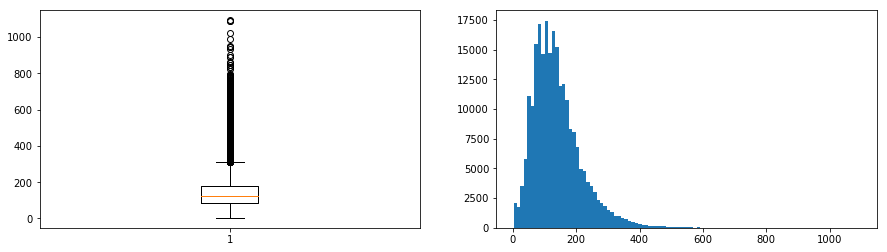

In [63]:
seq_len = [len(seq) for seq in sequences]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes[0].boxplot(seq_len)
axes[1].hist(seq_len, bins=100)
plt.show()

In [64]:
MAX_SEQ_LEN = 300
X_token_seq_all = pad_sequences(sequences, maxlen=MAX_SEQ_LEN, dtype='int32', padding='pre', truncating='post', value=0)
print(X_token_seq_all.shape)

(240387, 300)


## Vectorize output labels

In [65]:
%%time

labels = df_all.label.values
label_dict = {label: no for no, label in enumerate(set(labels))}
number_of_classes = len(label_dict)

# get labels as integers
y_all = [label_dict[label] for label in labels]

# change y to categorical (vectorize output)
y_all = np.array([to_categorical(i, num_classes=number_of_classes) for i in y_all])

CPU times: user 1.99 s, sys: 62.7 ms, total: 2.06 s
Wall time: 2.08 s


## Onehot encode Parse Tree labels

In [66]:
print(X_token_seq_all.shape)
X_token_seq_all

(240387, 300)


array([[0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       ..., 
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2]], dtype=int32)

In [67]:
%%time

EMBEDDING_DIM = VOC_SIZE

def get_vector(token):
    vector = np.zeros(EMBEDDING_DIM)
    if token != 0:
        vector[token-1] = 1
    return vector

X_token_seq_all_v = np.zeros((X_token_seq_all.shape[0], X_token_seq_all.shape[1] * EMBEDDING_DIM))
print(X_token_seq_all_v.shape)
i = 0
for token_seq in X_token_seq_all:
    X_token_seq_all_v[i] = np.array([get_vector(token) for token in token_seq]).flatten()
    i += 1
    
print(X_token_seq_all_v.shape)

(240387, 15000)
(240387, 15000)
CPU times: user 5min 53s, sys: 14 s, total: 6min 7s
Wall time: 6min 8s


In [68]:
%%time

# implementing 1D convolution ann as decribed in Keras tutorial
# https://keras.io/getting-started/sequential-model-guide/

from keras.models import Model
from keras.layers import Conv1D, Input, Flatten, Dropout, Dense, MaxPooling1D, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping

# reshape input to apply convolution
KERNEL_SIZE = 5

X_seq_input = X_token_seq_all_v.reshape(X_token_seq_all_v.shape[0], MAX_SEQ_LEN, EMBEDDING_DIM)
print(X_seq_input.shape)

postags = Input(shape=(MAX_SEQ_LEN, EMBEDDING_DIM), dtype='float32')
C1 = Conv1D(64, KERNEL_SIZE, activation='relu')(postags)
C1 = Conv1D(64, KERNEL_SIZE, activation='relu')(C1)
C1 = MaxPooling1D(KERNEL_SIZE)(C1)
C1 = Conv1D(128, KERNEL_SIZE, activation='relu')(C1)
C1 = Conv1D(128, KERNEL_SIZE, activation='relu')(C1)
C1 = GlobalAveragePooling1D()(C1)
C1 = Dropout(0.5)(C1)
C1 = Dense(100, activation='relu', name='sentence_vector_1')(C1)
C1 = Dropout(0.5)(C1)
preds = Dense(5, activation='softmax')(C1)

model = Model(postags, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

# learn
model.fit(X_seq_input[:X_train_cnt], y_all[:X_train_cnt], \
          validation_data=(X_seq_input[X_train_cnt:(X_train_cnt+X_valid_cnt)], \
                                 y_all[X_train_cnt:(X_train_cnt+X_valid_cnt)]), \
          callbacks=[EarlyStopping(patience=1, monitor='val_loss')], \
          verbose=1, epochs=20, batch_size=256)

model1 = model

(240387, 300, 50)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 300, 50)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 296, 64)           16064     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 292, 64)           20544     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 58, 64)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 54, 128)           41088     
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 50, 128)           82048     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 128)               0  

In [71]:
%%time

# implementing 1D convolution ann as decribed in Keras tutorial
# https://keras.io/getting-started/sequential-model-guide/

from keras.models import Model
from keras.layers import Conv1D, Input, Flatten, Dropout, Dense, MaxPooling1D, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping

# reshape input to apply convolution
KERNEL_SIZE = 5

X_seq_input = X_token_seq_all_v.reshape(X_token_seq_all_v.shape[0], MAX_SEQ_LEN, EMBEDDING_DIM)

postags = Input(shape=(MAX_SEQ_LEN, EMBEDDING_DIM), dtype='float32')
C1 = Conv1D(64, KERNEL_SIZE, activation='relu')(postags)
C1 = MaxPooling1D(KERNEL_SIZE)(C1)
C1 = Conv1D(128, KERNEL_SIZE, activation='relu')(C1)
C1 = GlobalAveragePooling1D()(C1)
C1 = Dropout(0.5)(C1)
C1 = Dense(100, activation='relu', name='sentence_vector_1')(C1)
C1 = Dropout(0.5)(C1)
preds = Dense(5, activation='softmax')(C1)

model = Model(postags, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

# learn
model.fit(X_seq_input[:X_train_cnt], y_all[:X_train_cnt], \
          validation_data=(X_seq_input[X_train_cnt:(X_train_cnt+X_valid_cnt)], \
                                 y_all[X_train_cnt:(X_train_cnt+X_valid_cnt)]), \
          callbacks=[EarlyStopping(patience=1, monitor='val_loss')], \
          verbose=1, epochs=20, batch_size=256)

model2 = model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 300, 50)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 296, 64)           16064     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 59, 64)            0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 55, 128)           41088     
_________________________________________________________________
global_average_pooling1d_6 ( (None, 128)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
sentence_vector_1 (Dense)    (None, 100)               12900     
__________

In [75]:
%%time

# implementing 1D convolution ann as decribed in Keras tutorial
# https://keras.io/getting-started/sequential-model-guide/

from keras.models import Model
from keras.layers import Conv1D, Input, Flatten, Dropout, Dense, MaxPooling1D, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping

# reshape input to apply convolution
KERNEL_SIZE = 10

X_seq_input = X_token_seq_all_v.reshape(X_token_seq_all_v.shape[0], MAX_SEQ_LEN, EMBEDDING_DIM)

postags = Input(shape=(MAX_SEQ_LEN, EMBEDDING_DIM), dtype='float32')
C1 = Conv1D(64, KERNEL_SIZE, activation='relu')(postags)
C1 = MaxPooling1D(KERNEL_SIZE)(C1)
C1 = Conv1D(128, KERNEL_SIZE, activation='relu')(C1)
C1 = GlobalAveragePooling1D()(C1)
C1 = Dropout(0.5)(C1)
C1 = Dense(100, activation='relu', name='sentence_vector_1')(C1)
C1 = Dropout(0.5)(C1)
preds = Dense(5, activation='softmax')(C1)

model = Model(postags, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

# learn
model.fit(X_seq_input[:X_train_cnt], y_all[:X_train_cnt], \
          validation_data=(X_seq_input[X_train_cnt:(X_train_cnt+X_valid_cnt)], \
                                 y_all[X_train_cnt:(X_train_cnt+X_valid_cnt)]), \
          callbacks=[EarlyStopping(patience=1, monitor='val_loss')], \
          verbose=1, epochs=20, batch_size=256)

model3 = model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 300, 50)           0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 291, 64)           32064     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 29, 64)            0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 20, 128)           82048     
_________________________________________________________________
global_average_pooling1d_9 ( (None, 128)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
sentence_vector_1 (Dense)    (None, 100)               12900     
__________

## Save model

In [76]:
model1.save('input/Extension_Part1_CONV1_CONSTPARSE1.h5')
model2.save('input/Extension_Part1_CONV1_CONSTPARSE2.h5')
model3.save('input/Extension_Part1_CONV1_CONSTPARSE3.h5')